# BCR analysis in Scirpy

In [2]:
# not part of the tutorial, but temporarily surpresses distracting warnings
import warnings
from numba import NumbaDeprecationWarning

warnings.simplefilter(action="ignore", category=(FutureWarning, NumbaDeprecationWarning))

In [3]:
# import all necessary python packages for this tutorial
import muon as mu
import scanpy as sc
import scirpy as ir
import numpy as np

sc.set_figure_params(figsize=(5, 5))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

C:\Users\km930\anaconda3\envs\BCR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this tutorial, we guide the user through single cell {term}`BCR <BCR>` analysis with `Scirpy`. The functionality in this notebook requires Scirpy v0.19 or later. Additionally, we leverage the interoperability with Dandelion {cite}`Suo.2023` for certain preprocessing steps. 

This tutorial uses a dataset from Stephenson et al. {cite}`Stephenson2021`. The original dataset consists of 143 samples and > 60k B cells from patients with COVID-19 in different degrees of severity and three control groups. To simplify and speed up the computation, we included cells from the five most abundant COVID-19 positive samples per status category and randomly subsampled down to 5k.

In [5]:
sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


## Pre-processing/Re-annotation
Unlike TCR data, it is not recommended to directly use the output of Cell Ranger while analysing scBCR-data. Best practice is to re-annotate Cell Ranger gene annotation with IgBlast or IMGT/HighV-QUEST, because Cell Ranger currently does not support the IMGT unique numbering scheme {cite}`Lefranc.2003`, which is heavily used by many downstream analysis tools e.g. phylogenetic analysis and mutation inference.

Our data used in this notebook is already re-annotated and pre-processed and cells have already passed transcriptome quality control as described [by the original authors](https://www.nature.com/articles/s41591-021-01329-2#Sec8). This tutorial does not present an exemplary workflow on how to re-annotate contigs based on Cell Ranger fasta and annotation files, as this functionality is beyond the scope of `Scirpy`. Instead, we recommend to use Dandelion {cite}`Suo.2023` for this step as described in their [tutorial on their website](https://sc-dandelion.readthedocs.io/en/latest/notebooks/1_dandelion_preprocessing-10x_data.html#). Note, that `Scirpy` offers two functions ({func}`scirpy.io.from_dandelion`and {func}`scirpy.io.to_dandelion`), that allow for convenient transformation between `Dandelion class` objects and `AnnData` objects.

Alternatively, it is possible to pre-processing of Cell Ranger output with the [Immcantation suite](https://immcantation.readthedocs.io/en/stable/index.html) and a comprehensive tutorial is presented [on their website](https://immcantation.readthedocs.io/en/stable/getting_started/10x_tutorial.html). Re-annotation will finally result into a AIRR-C Format `.tsv` file, which can be loaded into Scirpy using {func}`scirpy.io.read_airr` for further use.

### Germline reconstruction
Germline sequences, primarily required for calculating mutations, can enrich your pre-processed data. Although `Scirpy` does not currently support germline sequence inference, it's recommended to leverage its interoperability with `Dandelion` for this purpose, as detailed in this [tutorial](https://sc-dandelion.readthedocs.io/en/latest/notebooks/5_dandelion_diversity_and_mutation-10x_data.html) on their website. This tutorial will later cover mutation calculation. Note that germline sequences can also be useful for other applications, like phylogenetic analysis, which are beyond the current scope of `Scirpy`.

## Importing data
Data import into `Scirpy` from various formats is straightforward, as described in the {ref}`dedicated tutorial on data loading <importing-data>`. In this case, we directly load the demo dataset: 

In [9]:
# TODO make demo dataset available
mdata = mu.read_h5mu("stephenson_5K_2021.h5mu")

# minimal working example importing data from Cell Ranger:
# adata_bcr = ir.io.read_10x_vdj("XXX_filtered_contig_annotations.csv.gz")

# Load the associated transcriptomics data
# adata = sc.read_10x_h5("XXX_filtered_feature_bc_matrix.h5")
# adata.var_names_make_unique()

# combine into MuData object
# mdata = mu.MuData({"gex": adata, "airr": adata_bcr})

C:\Users\km930\anaconda3\envs\BCR\lib\site-packages\anndata\utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


`mdata` is a {class}`~mudata.MuData` object, which is a framework for multimodal data analysis with a strong focus on multi-omics. It essentially builds on top of [`AnnData`](https://anndata.readthedocs.io/en/latest/index.html) and its general usage is outlined in {ref}`Scirpy's data structure <data-structure>`.

In [11]:
mdata

MuData object with n_obs × n_vars = 5000 × 24929
  2 modalities
    gex:	5000 x 24929
      obs:	'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id'
      var:	'feature_types'
      uns:	'gex:initial_clustering_colors', 'gex:patient_id_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_pca_harmony', 'X_umap'
      layers:	'raw'
    airr:	5000 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices', 'scirpy_version'
      obsm:	'airr', 'chain_indices'

## BCR Quality Control
Although many {term}`AIRR` analysis tools recommend to only include single paired AIR sequences, there is increasing evidence that {term}`allelically <Alellically included B-cells>` and {term}`isotypically included B cells <Isotypically included B-cells>` are quite common {cite}`Zhu.2023`. During the QC process, the user can decide to filter or keep these cases as appropriate for their analysis. 

The demo dataset used here is already pre-filtered, and filtering steps are shown for the sake of completeness below. Typically, we suggest to remove cells flagged as `orphan`, because they cannot be utilized for downstream analyses that require full AIR sequence information. Similarly, cells flagged as `multichain` are likely [undetected doublets](https://www.sc-best-practices.org/air_repertoire/ir_profiling.html#quality-control) and should be excluded.

:::{note}
**Standard *Scirpy* preprocessing workflow**

1. {func}`scirpy.pp.index_chains`: create {ref}`chain indices <chain-indices>` for the receptor data
2. {func}`scirpy.tl.chain_qc`: add a summary about the immune cell-receptor compositions to `.obs`
3. filter as desired
:::

For more information regarding preprocessing and filtering, especially for transcriptomics data, please refer to the [single cell best practice book](https://www.sc-best-practices.org/preamble.html). If you want to gain a better understanding regarding the function calls shown below, please have a look on our dedicated [T cell tutorial](https://scirpy.scverse.org/en/latest/tutorials/tutorial_3k_tcr.html#creating-chain-indices)

In [13]:
ir.pp.index_chains(mdata, filter=["productive", "require_junction_aa"])
ir.tl.chain_qc(mdata)
mu.pp.filter_obs(
    mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ", "ambiguous", "multichain"])
)

## Preprocessing Transcriptomics Data

Certain analyses can combine transcriptomics and AIRR information. Gene expression (GEX) data  needs to be filtered and preprocessed as with any other single-cell dataset. Please refer for a real dataset to the [scverse tutorials](https://scverse.org/learn/)
and the [single-cell best practice book](https://sc-best-practices.org/) for advice. The transcriptomics data in this demo dataset has already been prepared appropriately. 

## Define Clonotype Cluster for BCR
The general workflow of defining BCR/TCR clonotype clusters is depicted below:
```{eval-rst}
.. list-table:: Analysis steps on IR data
    :widths: 40 60
    :header-rows: 1

    - - scirpy function
      - objective
    - - :func:`scirpy.pp.ir_dist`
      - Compute sequence-based distance matrices for all :term:`VJ <Chain locus>` and
        :term:`VDJ <Chain locus>` sequences.
    - - :func:`scirpy.tl.define_clonotype_clusters`
      - Cluster cells by the similarity of their CDR3-sequences.
    - - :func:`scirpy.tl.clonotype_network`
      - Compute layout of the clonotype network.
    - - :func:`scirpy.pl.clonotype_network`
      - Plot clonotype network colored by different parameters.
```

In `Scirpy` we generally distinguish between {term}`clonotypes <Clonotype>` (group of cells that have the same anscestor and identical receptors) and {term}`clonotype clusters <Clonotype cluster>` (group of cells that have similar receotors). Because of {term}`somatic hypermutation <SHM>` the above definition of clonotypes wouldn't correctly represent clonal relationship in the case of BCR, and therefore we have to define certain criteria to cluster similar sequences into clonotype clusters.

Currently, there is no commonly agreed best practice on how to define clonotype cluster for BCR sequences, and it remains an active research field {cite}`Yaari.2015`. In `Scirpy`, we implemented a simple, yet effective, network-based approach to define BCR clonotype clusters {cite}`Balashova.2024` leveraging the same underlying functionality we had already in place for TCRs. 

With {func}`scirpy.pp.ir_dist` we can calculate the full pairwise-distance matrix between each junction sequence for each light and heavy chain in the dataset. For BCRs, we recommend the `normalized_hamming` distance which calculates the hamming distance between junction sequences normalized to their respective length applied to nucleotides (`sequence = nt`) rather than amino acids (`sequence = aa`), because SHM acts on the nucleotide level {cite}`Yaari.2015`. 

To choose a distance cutoff, we can either use a generic threshold of e.g. 85% junction similarity (`cutoff = 15`), or choose one based on the empirical distribution of distances. 
To this end, setting `min_dist_histogram = True` will display the distance-to-nearest distribution of the junction sequences between VJ-chains (light) and VDJ-chains (heavy), respectively. A cutoff is commonly selected such that it separates the bimodality between sequences with closely related sequences from sequences without closely related sequences {cite}`Gupta.2017`.

However, as it is apparent by the following histogram this process can be subjective, and sometimes no clear bimodality can be observed. It is generally true that distance-to-nearest plots are bimodal, but it can be difficult to identify one distinct threshold, especially for small datasets{cite}`Gupta.2017`. In such cases, we suggest to use conservative fixed thresholds to minimize human bias.

Computing sequence x sequence distance matrix for VJ sequences.


Calculating Hamming Distances: 100%|█████████████████████████████████████████████| 3624/3624 [00:02<00:00, 1484.07it/s]


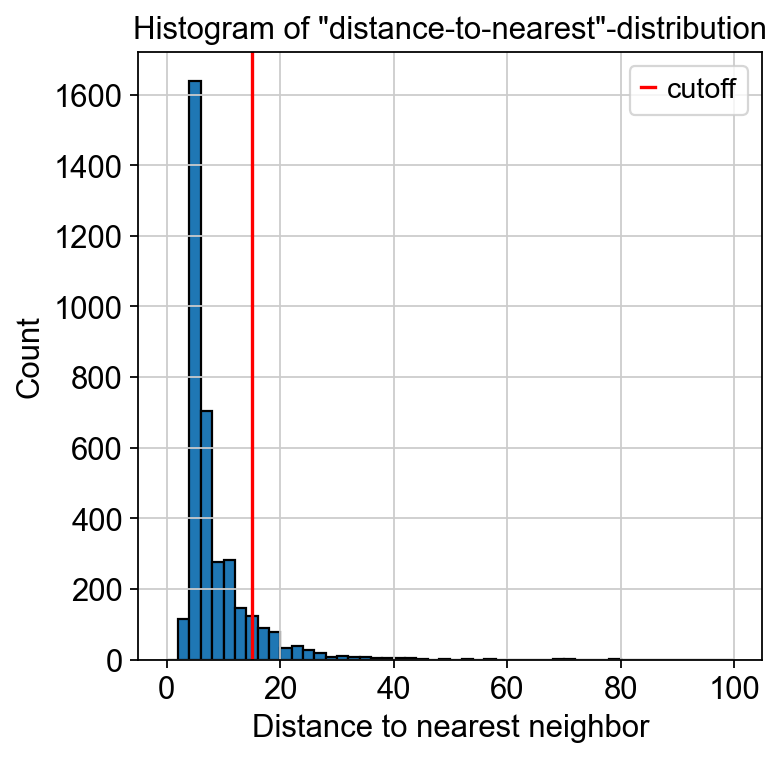

Computing sequence x sequence distance matrix for VDJ sequences.


Calculating Hamming Distances: 100%|█████████████████████████████████████████████| 5020/5020 [00:01<00:00, 3168.87it/s]


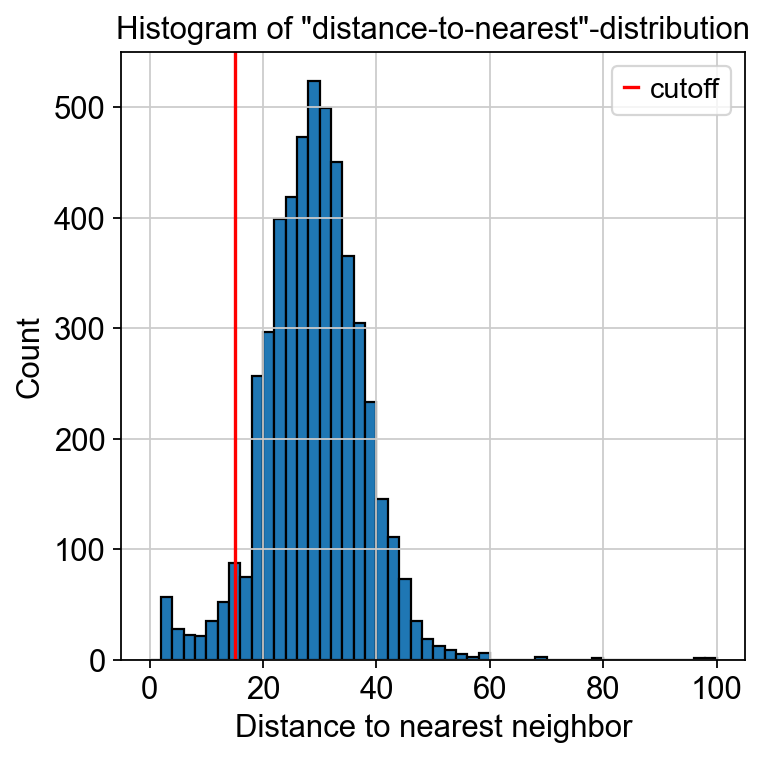

In [18]:
ir.pp.ir_dist(mdata, metric="normalized_hamming", cutoff=15, sequence="nt", min_dist_histogram=True)

Next up, calling {func}`scirpy.tl.define_clonotype_clusters` will actually define the clonotype clusters based on the distances of the {term}`VJ <V(D)J>` and {term}`VDJ <V(D)J>` CDR3-sequences (calculated by {func}`scirpy.pp.ir_dist`) and further parameters. To identify cells that originate from the same ancestor, we require them to have the same V-gene (`same_v_gene = True`) and J-gene (`same_j_gene = True`) segments {cite}`Yaari.2015`. Using `receptor_arms = "all"` and `dual_ir = "any"` ensures that both heavy and light chains need to match {cite}`DeKosky.2013`, and is lenient about some cells having a secondary chains where others might have none.  Setting `within_group` to  an `.obs` column will ensure cells with  different values do not cluster together (e.g. use patient_id to ensure there are no "public" clonotypes). Dealing with allelically/isotypically included B cells in sc-data is still in its upcoming may require some experimentation with the `dual_ir` parameter.


:::{note}
<!-- TODO fix this in scirpy, see https://github.com/scverse/scirpy/issues/561 -->
Re-annotation with IgBlast/IMGT-HighV-QUEST causes at the moment some issues in *Scirpy* as it commonly integrates allele information as part of the gene annotation (after the asterisk(\*)) and will include ambiguous gene annotations (more than one annotation per gene). At the time, manually manipulating both v_call and j_call columns of the respective files prior to import into *Scirpy* seems to be an acceptable workaround.
:::

These restrictions are used to construct a network where each node represents a unique junction sequence ({term}`clonotypes <Clonotype>`) and the size of the node represents how many identical sequences this node contains. Nodes that pass all specifications of {func}`scirpy.tl.define_clonotype_clusters` will be connected by an edge. 

Lastly, `partitions` will specify the algorithm that is used for [community detection in igraph](https://igraph.org/c/doc/igraph-Community.html). `partitions = "fastgreedy"` will initiate a greedy hierarchical clustering algorithm, which might lead to some smaller subclusters, especially if cluster are weakly connected {cite}`Clauset.2004`. In practice, this makes little difference in scirpy, since edges representing a distance exceeding the `cutoff` threshold will automatically be elimitated to improve computational efficiency, already leading to disconnected partitions.

{func}`scirpy.tl.define_clonotype_clusters` will add a `clone_id` and a `clone_id_size`column to `.obs`, which can be customized with `key_added`.

In [20]:
ir.tl.define_clonotype_clusters(
    mdata,
    sequence="nt",
    metric="normalized_hamming",
    receptor_arms="all",
    dual_ir="any",
    same_v_gene=True,
    same_j_gene=True,
    # within_group = "gex:patient_id", not allowing for public clonotypes
    partitions="fastgreedy",
    key_added="clone_id_85_similarity",
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.
community_fastgreedy clustering:
modularity score:  0.47305973083806097
membership:  [0, 1, 2, 3, 4, 5, 6, 2, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 16, 2, 17, 18, 19, 20, 21, 22, 23, 24, 2, 25, 26, 27, 28, 29, 30, 31, 32, 33, 2, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 42, 9, 77, 78, 79, 80, 81, 82, 40, 83, 13, 84, 85, 86, 87, 88, 89, 90, 91, 79, 92, 93, 9, 94, 95, 43, 96, 2, 97, 43, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 43, 111, 112, 113, 114, 115, 116, 117, 43, 118, 119, 120, 65, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 101, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 1, 146, 147, 148, 149, 150, 151, 8, 152, 153, 154, 155, 156, 157, 158, 40, 159, 160, 161, 162, 163, 164, 165, 166, 2, 167, 2, 168, 169, 170, 171, 75, 118, 17

Calling {func}`scirpy.tl.clonotype_network` will compute the layout for the clonotype network needed for visualization. Setting `min_cells` to an appropriate value is especially important for big datasets to avoid overcrowding the plot. Here, we set it to three to be more conservative and only show clonotype clusters that are certainly expanded.

In [22]:
ir.tl.clonotype_network(
    mdata, sequence="nt", metric="normalized_hamming", min_cells=3, clonotype_key="clone_id_85_similarity"
)

{func}`scirpy.pl.clonotype_network` will display a customizable clonotype network. `color` can be set to any `.obs` column. Here we see that most expanded clonotype clusters belong to either `Moderate` and `Severe` patients. It also indicates that no clonotype cluster is shared between patients, which can be shown systematically by using the patient IDs stored inside `mdata.obs["gex:patient_id]`

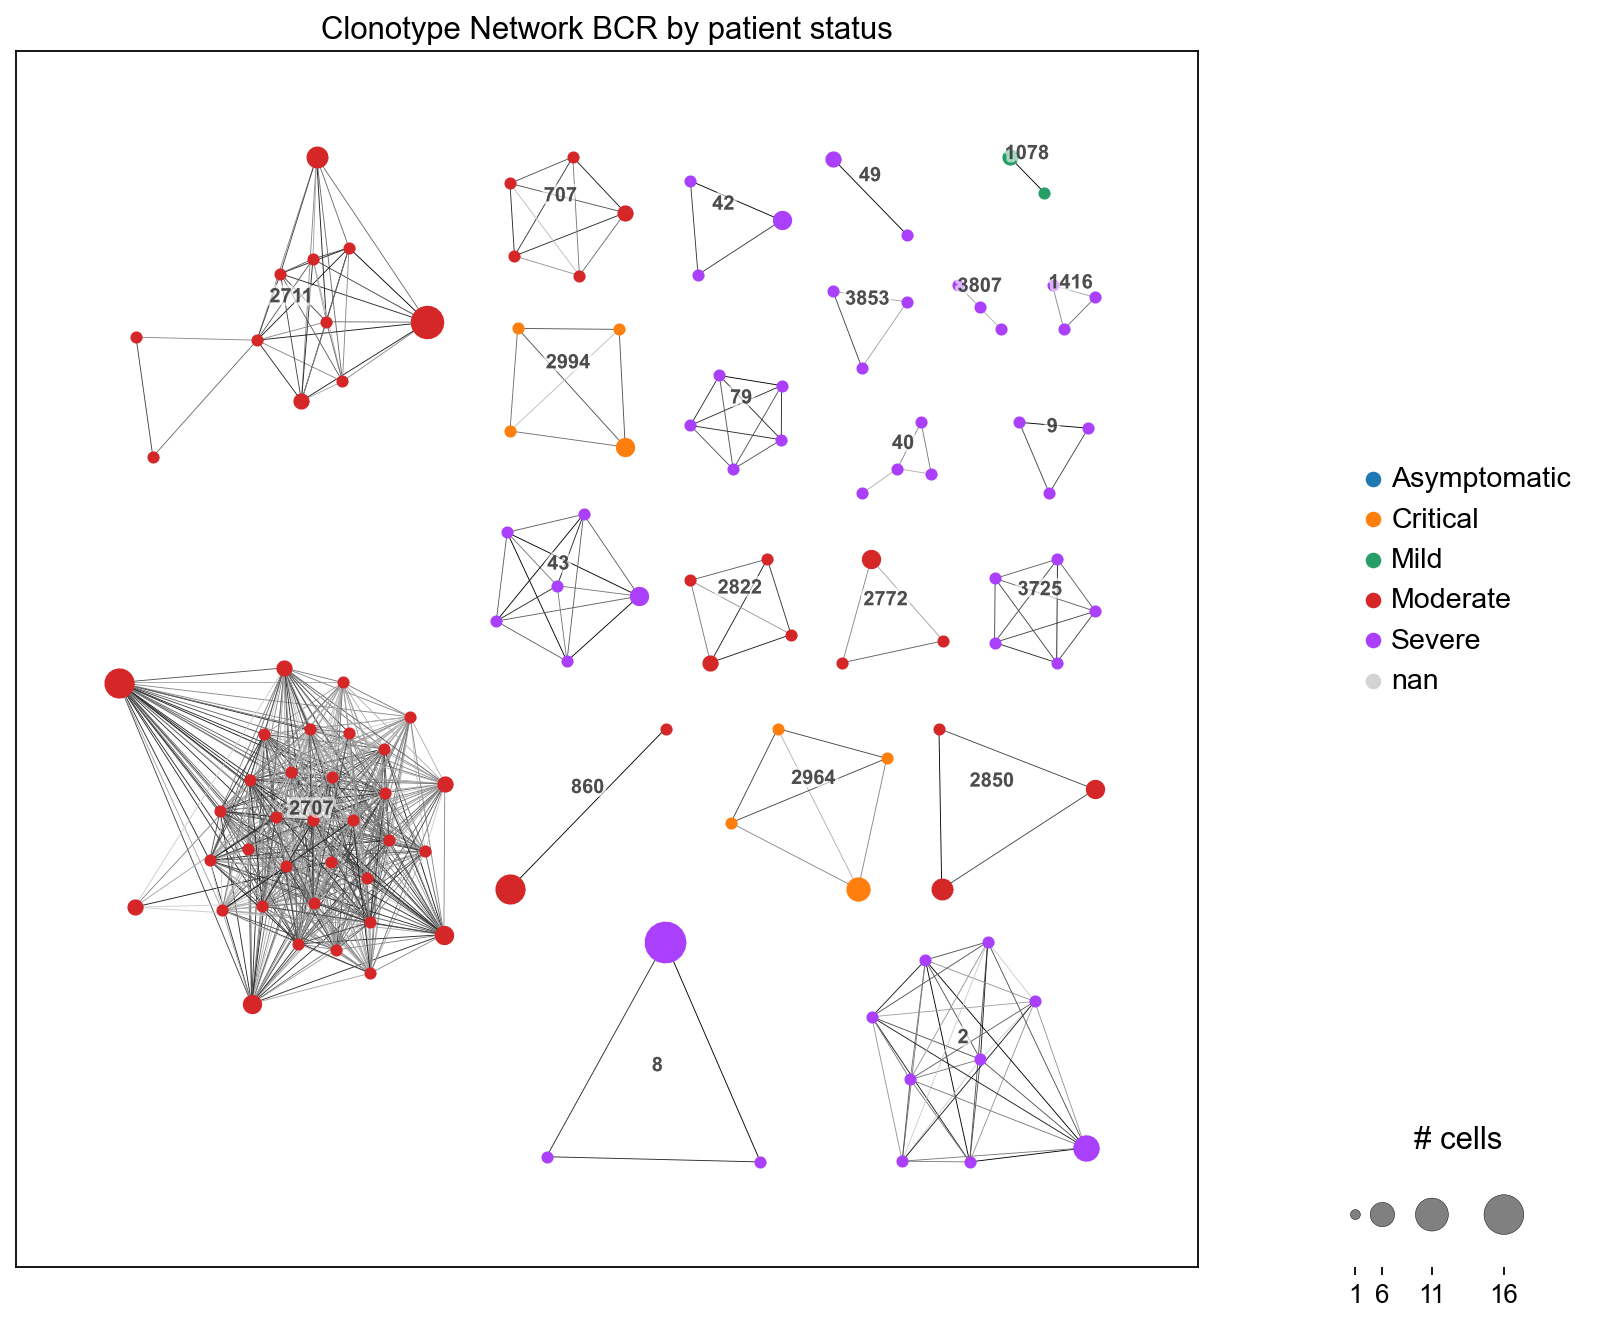

In [24]:
_ = ir.pl.clonotype_network(
    mdata,
    color="gex:Status_on_day_collection_summary",
    title="Clonotype Network BCR by patient status",
    label_fontsize=9,
    base_size=20,
)

## Repertoire Analysis

### Clonotype Expansion

Upon infection, some precursor lymphocytes that recognize an invading antigen proliferate into cells with various phenotypes that establish an appropriate immune response in a process called clonal/clonotype expansion {cite}`Adams.2020`. Clonotype expansion is a way to characterize the immune response and has therefore important implications for immunology.

{func}`scirpy.tl.clonal_expansion` adds a label (inside `.obs`) showing if there is another cell with the same clonotype id or not. The fineness of the assignment can be controlled with the `breakpoints` parameter. This new column is useful to conveniently access information about clonal expansion among different groups.

In [27]:
ir.tl.clonal_expansion(mdata, target_col="clone_id_85_similarity", breakpoints=(1, 2))
expanded = np.sum(mdata.obs["airr:clonal_expansion"] != "<= 1") / len(mdata)
print(f" There are {expanded:.2%}% expanded (size >=2) clonotype cluster in this subsample.")

Stored result in `mdata.obs["airr:clonal_expansion"]`.
 There are 6.04% expanded (size >=2) clonotype cluster in this subsample.


This new column is a good fit for {func}`scirpy.pl.group_abundance`, which is designed to quickly visualize categorical data. Here it's likely that expanded clonotypes are preferential found in cells labelled as plasma cells and plasmablast. This would make sense as these cell types are primarily involved in the humoral immune response upon infection and proliferate rapidly {cite}`Nutt.2015`.

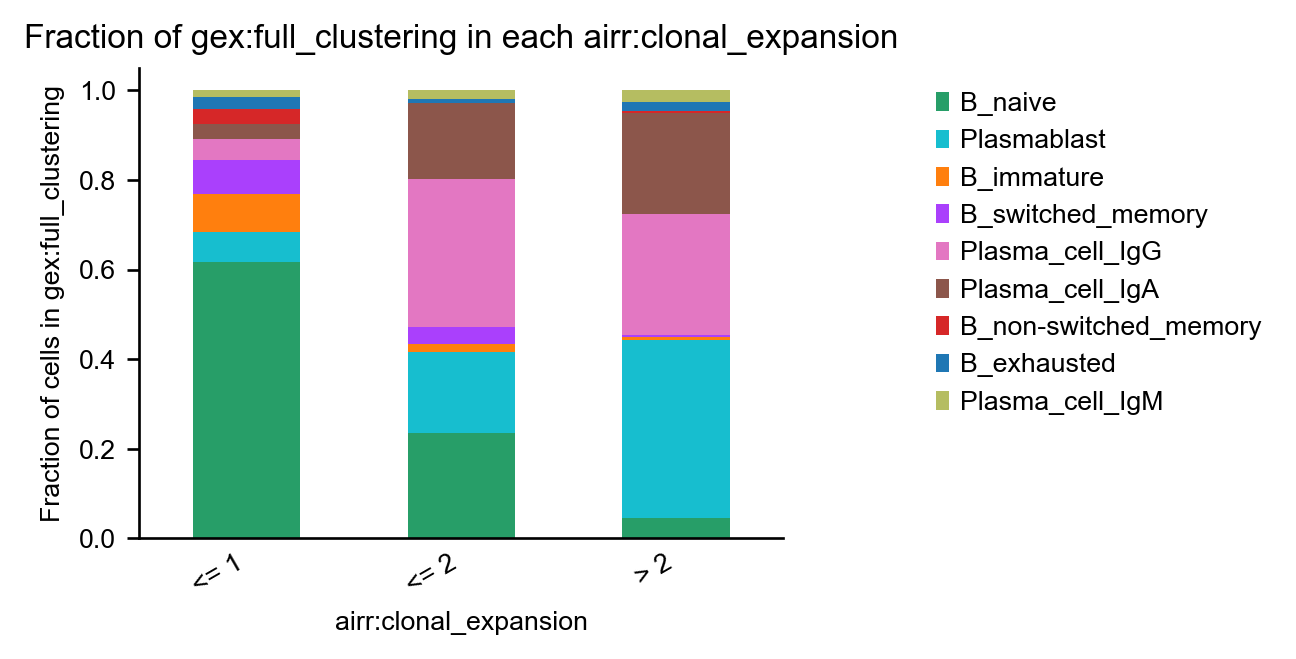

In [29]:
_ = ir.pl.group_abundance(
    mdata,
    target_col="gex:full_clustering",
    groupby="airr:clonal_expansion",
    sort=["<= 1", "<= 2", "> 2"],
    normalize=True,
)

Alternatively, clonal expansion can be visualized using {func}`scirpy.pl.clonal_expansion`. Each bar will represent one group defined `groupby` and each colour will identify one clonal expansion breakpoint defined by `breakpoints`.

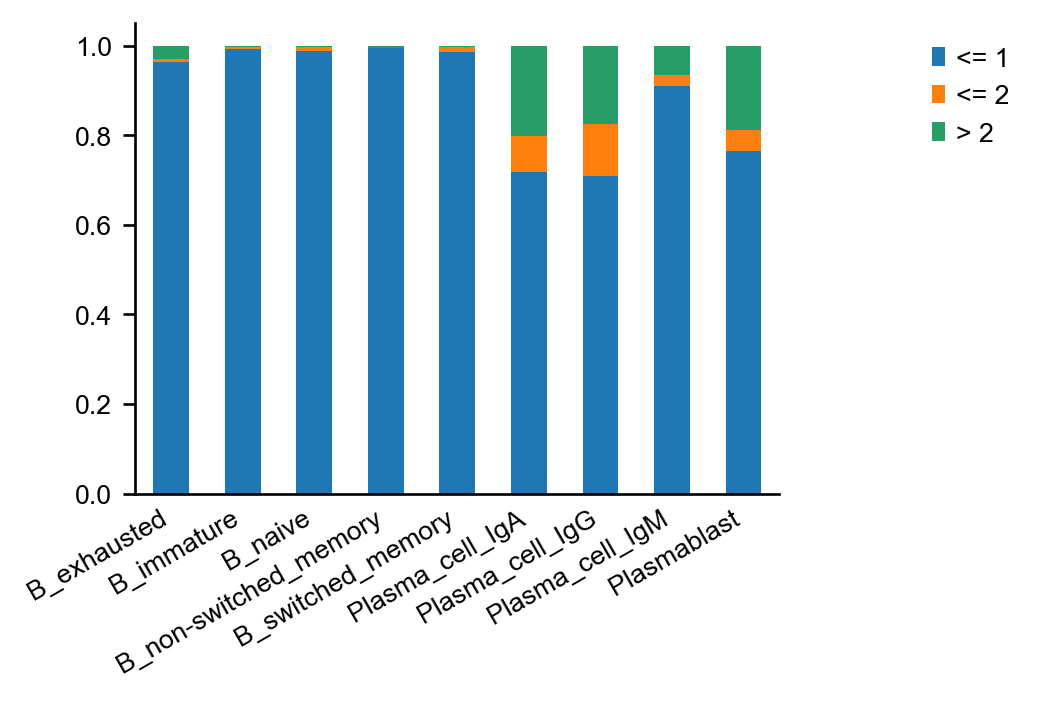

In [31]:
_ = ir.pl.clonal_expansion(
    mdata,
    target_col="clone_id_85_similarity",
    breakpoints=(1, 2),
    groupby="gex:full_clustering",
    normalize=True,
)

### Clonotype Diversity

TODO

### Clonotype Abundance

Sometimes it might be desired to investigate the biggest clonotype cluster, which can be accomplished with calling {func}`scirpy.pl.group_abundance`. It is worth mentioning that plots are easily normalized to any data inside `.obs` by setting the `normalize` parameter accordingly.

Here, we can see that each of the 10 largest clonotype cluster span across at least two cell type annotations.

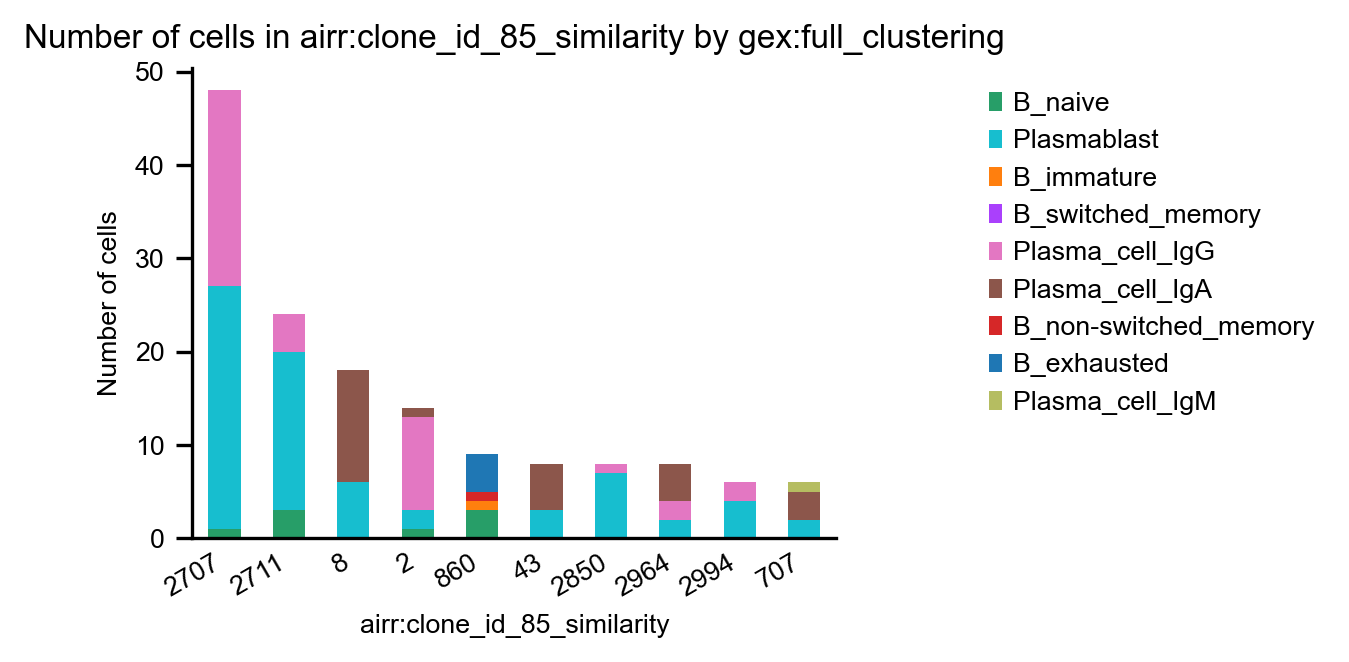

In [46]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id_85_similarity",
    target_col="gex:full_clustering",
    max_cols=10,
    # normalize = "gex:patient_id" => this would normalise column height based on how many cells per patient were analysed
)

### Gene usage

Gene annotation can be utilized to investigate gene usage for various categories like patient related information (e.g. status, disease, treatment) or cell type annotation. By using {func}`scirpy.get.airr_context` as a context manager any column stored inside the awkward array can be temporarily added to the MuData object.

Below, this was applied to visualize gene usage per patient-status. Note that most of the most used genes belong to gene family IGHV3 and IGHV4.

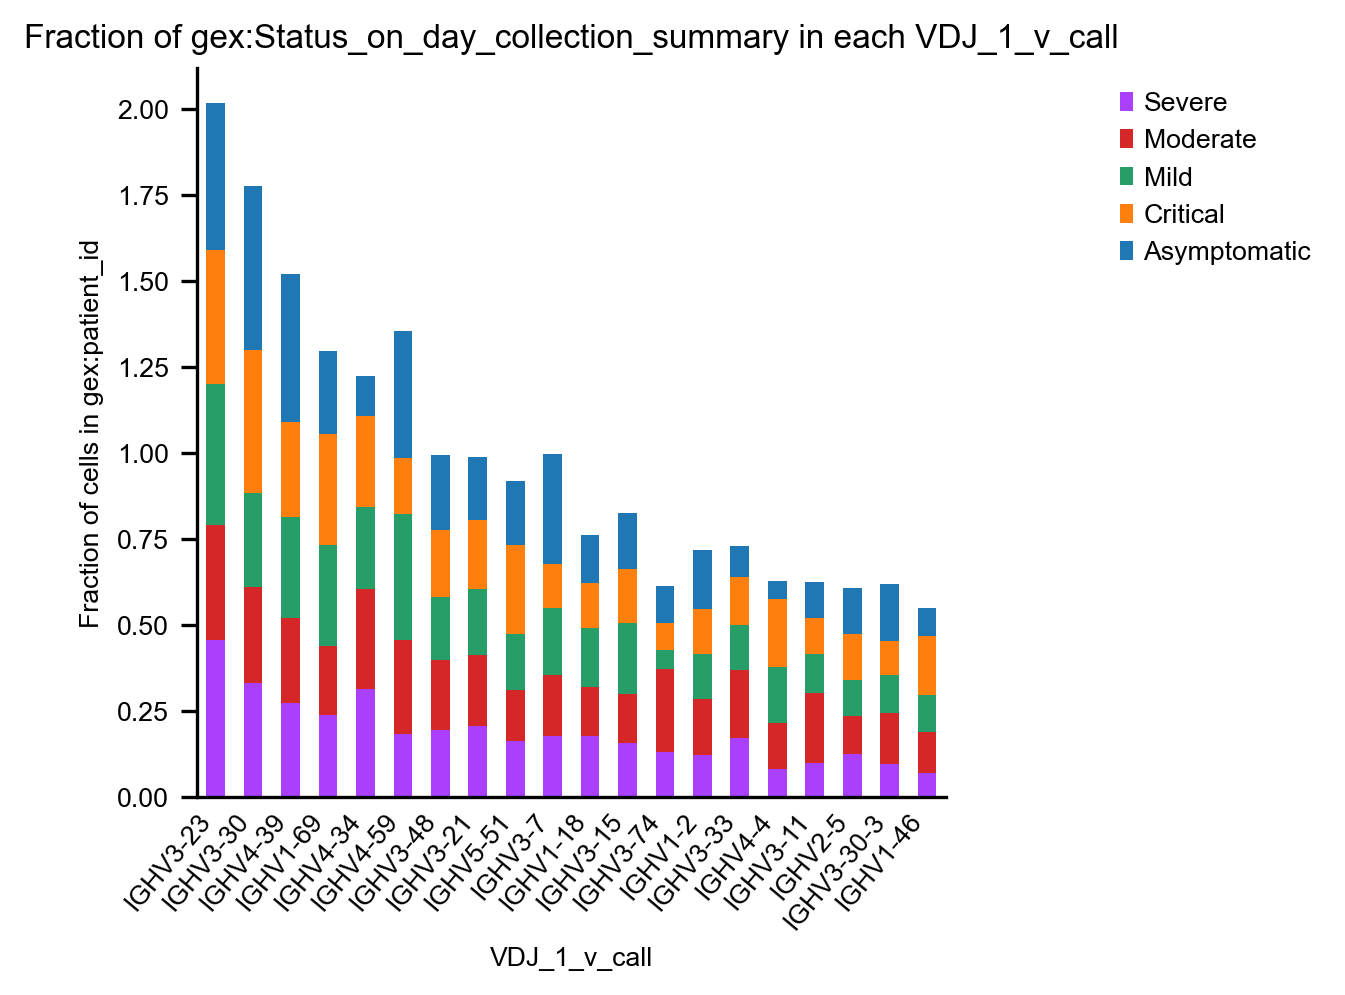

In [49]:
with ir.get.airr_context(mdata, "v_call"):
    ax_Status = ir.pl.group_abundance(
        mdata,
        groupby="VDJ_1_v_call",
        target_col="gex:Status_on_day_collection_summary",
        normalize="gex:patient_id",
        max_cols=20,
        figsize=(4, 4),
    )
_ = ax_Status.set_xticklabels(ax_Status.get_xticklabels(), rotation=50, ha="right")

To quickly get an overview of the exact combination of V(D)J genes {func}`scirpy.pl.vdj_usage` can be used. It will plot all gene combinations of the dataset as a Sankey-plot.

<Axes: >

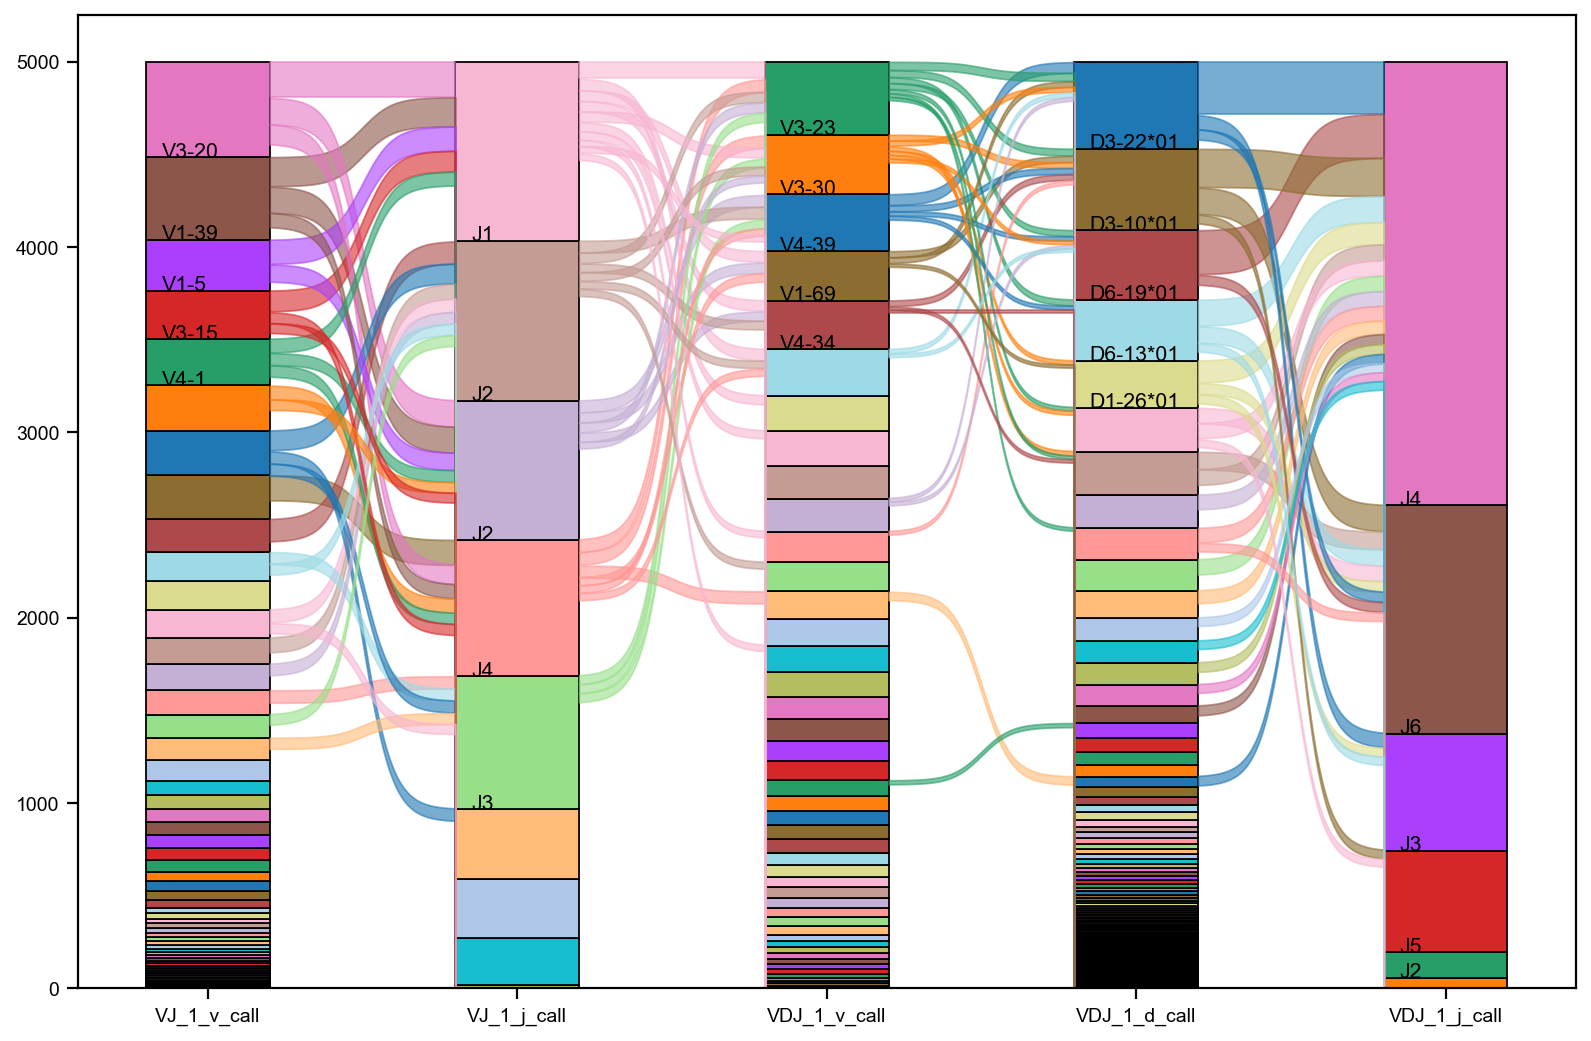

In [51]:
ir.pl.vdj_usage(
    mdata,
    vdj_cols=("VJ_1_v_call", "VJ_1_j_call", "VDJ_1_v_call", "VDJ_1_d_call", "VDJ_1_j_call"),
    full_combination=False,
    max_segments=None,
    max_ribbons=30,
    fig_kws={"figsize": (12, 8)},
)

A lot of this tutorial was focused on the primary heavy chain, as it is considered to be more diverse compared to the light chain and thus be potentially more interesting for analysis. Either way, analysing the light chain works similarly and yields also insightful information. Further, it is possible to analyse allelically included b cells with a secondary heavy and/or light chain contig as well.

### Spectratype analysis
Spectratype analysis is another way to describe heterogeneity of the V(D)J sequences. The V(D)J-recombination mechanism brings together different gene segments and might introduce insertions and/or deletions of nucleotides between genes segments, which leads to a broad spectrum of lengths of the resulting transcript {cite}`Kenneth.2017`. For easy access, *Scirpy* offers {func}`scirpy.pl.spectratype` that plots a distribution by summarizing the length of the junction (CDR3) region for all cells and chains.

Using {func}`scirpy.pl.spectratype` shows that while the spectratype distribution of the whole dataset is almost a normal distribution with a peak at 16 amino acids, there might be a preferential usage of spectratypes with length 20 for expanded clonotype clusters. Note that spectratypes of length 16 in expanded cells are far less abundant than expected after seeing the spectratype distribution of the whole dataset.

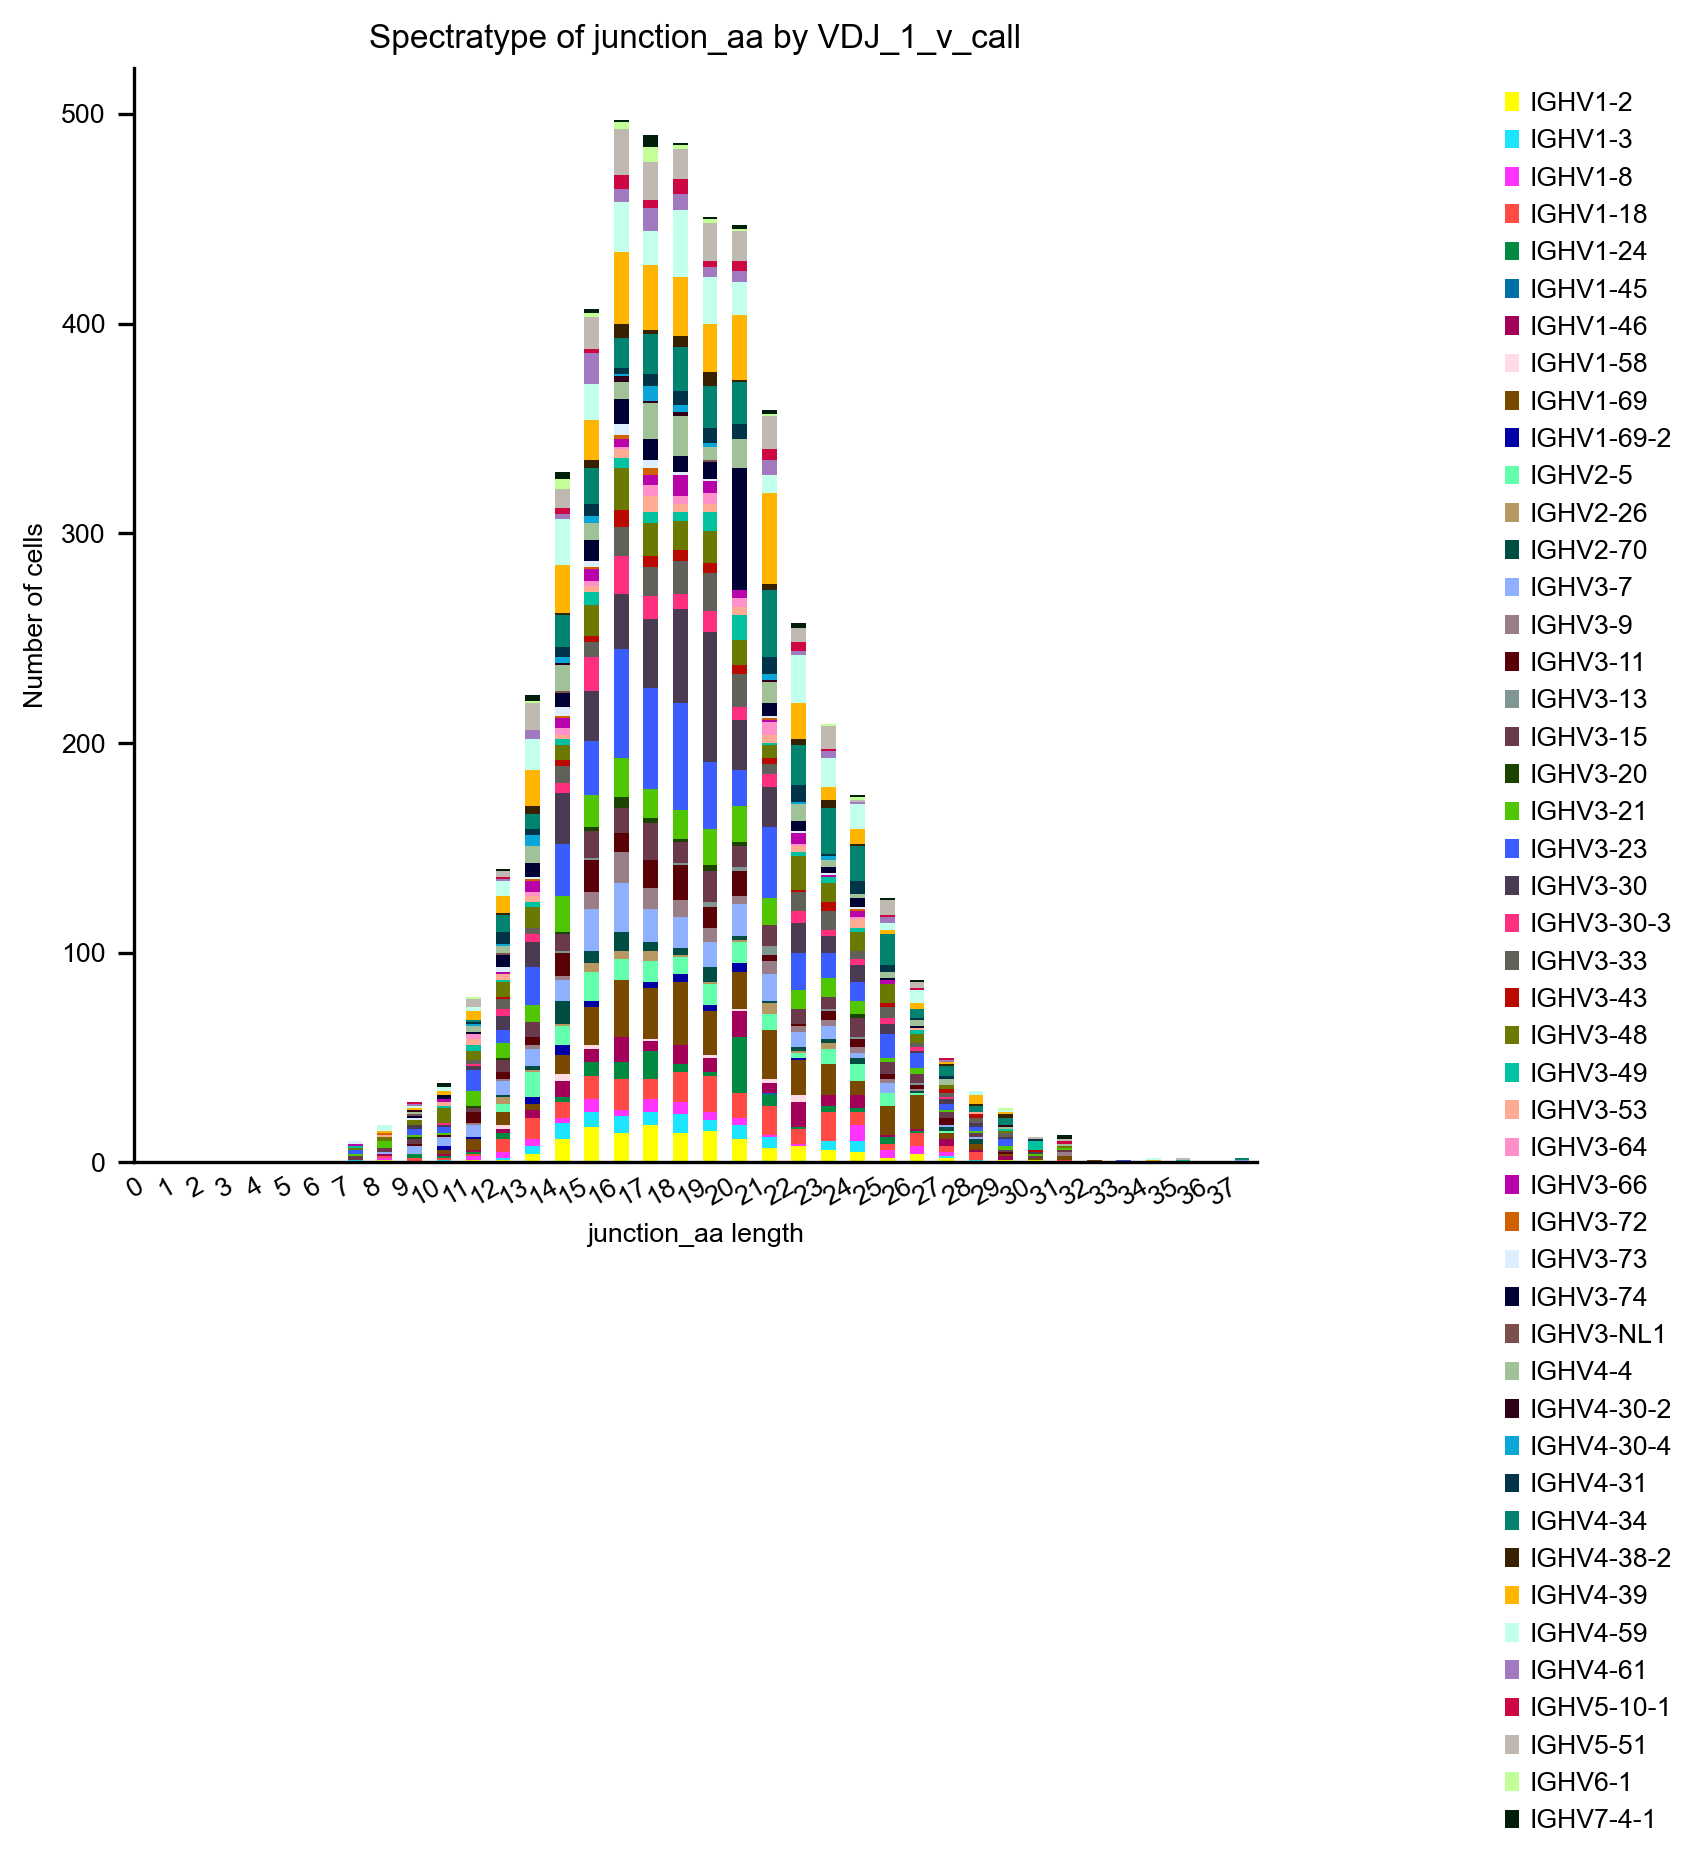

In [54]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.spectratype(mdata, chain=["VDJ_1"], color="VDJ_1_v_call", viztype="bar", fig_kws={"dpi": 120}, figsize=[6, 6])

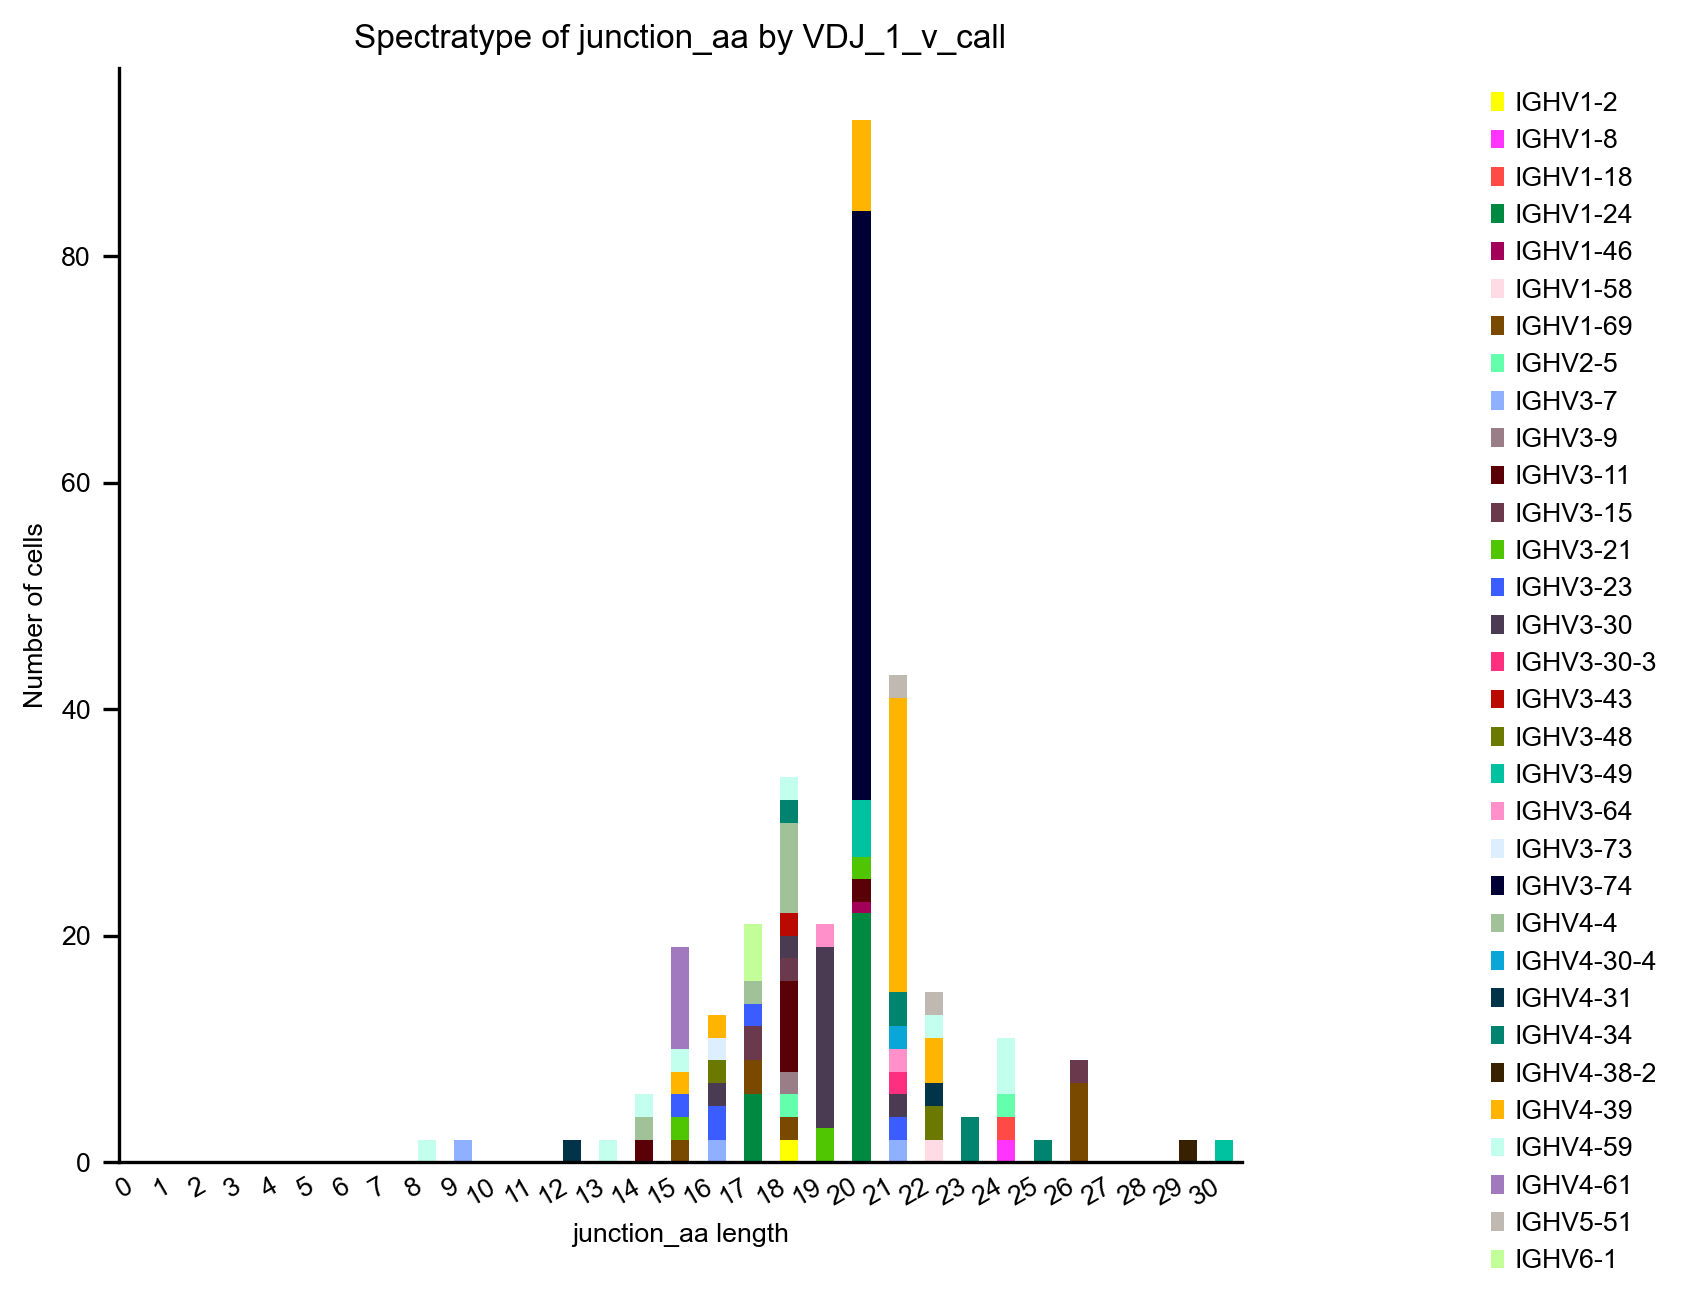

In [55]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.spectratype(
        mdata[
            mdata.obs["airr:clonal_expansion"].isin(["<= 2", "> 2"]),
            :,
        ],
        chain=["VDJ_1"],
        cdr3_col="junction_aa",
        color="VDJ_1_v_call",
        viztype="bar",
        fig_kws={"dpi": 120},
        figsize=[6, 6],
    )

Probably a better way to visualize the spectratype distribution between different categories (like cells/patients) is by setting `viztype = "curve"` and the `curve_layout = "shifted"` to "shifted". This will visualize all distinct categories as a "ridge-plot". As we can see below, it might be entirely possible that plasmablasts contribute towards this peak at 20 aa for expanded clonotype clusters as the junction sequence distribution of this particular cell type seems to be skewed towards longer spectratypes and plasmablasts were preferentially expanded.

C:\Users\km930\Scirpy_Git_pushes\Scirpy_Felix_synchro\scirpy_BCR\scirpy_mario\scirpy\pl\base.py:261: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order)


<Axes: title={'center': 'Spectratype of junction_aa by gex:full_clustering'}, xlabel='junction_aa length'>

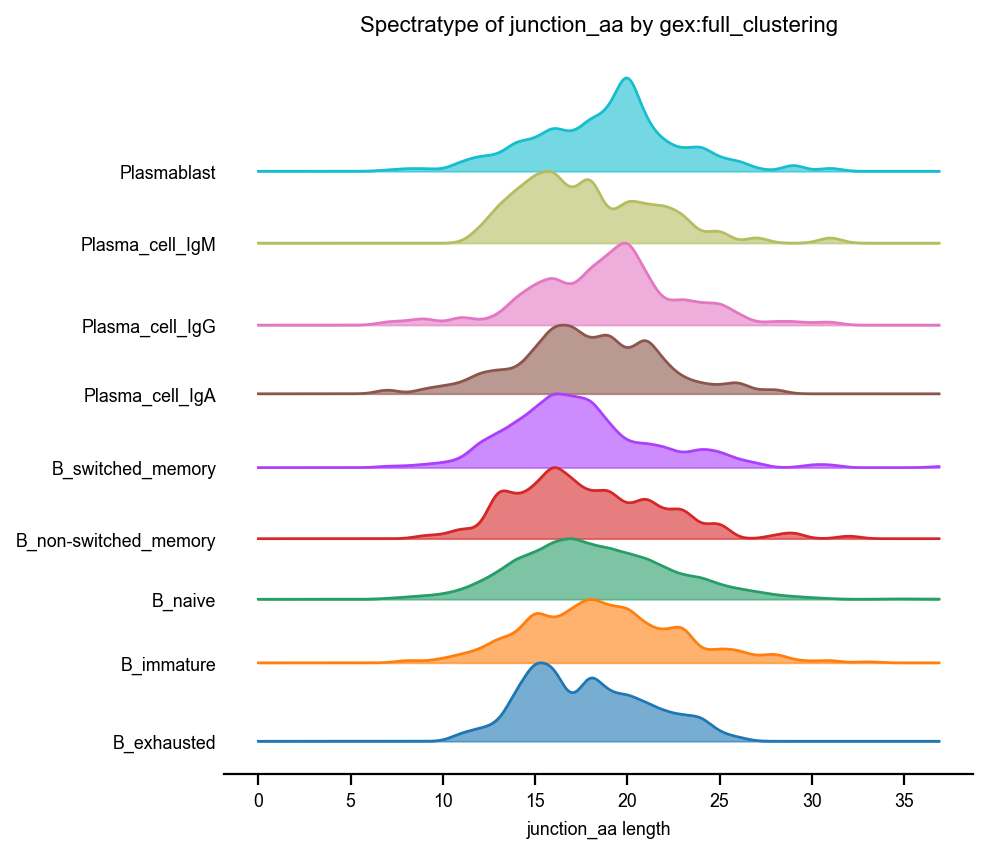

In [57]:
ir.pl.spectratype(
    mdata,
    cdr3_col="junction_aa",
    chain="VDJ_1",
    color="gex:full_clustering",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"figsize": [6, 6]},
    kde_kws={"kde_norm": False},
)

Arguably one of the biggest advantages is to seamless use all *Scanpy* functionalities while using *Scirpy* for analysis. So instead of analysing/visualizing categorical data via "ridge"-plots it's entirely possible to use violinplots as well. Because *Scanpy* doesn't support `MuData` objects (yet) we'll have to introduce a small workaround. The context manager {func}`scirpy.get.obs_context` allows to temporary store any relevant information into the `.obs` column from any modality. This way, one modality can be used as an AnnData object with additional information through {func}`scirpy.get.obs_context`, which will work just fine for *Scanpy's* functions.

Below, this was applied to create a violinplot with Scanpy's `scanpy.pl.violin` to observe potential differences among patient-status groups.

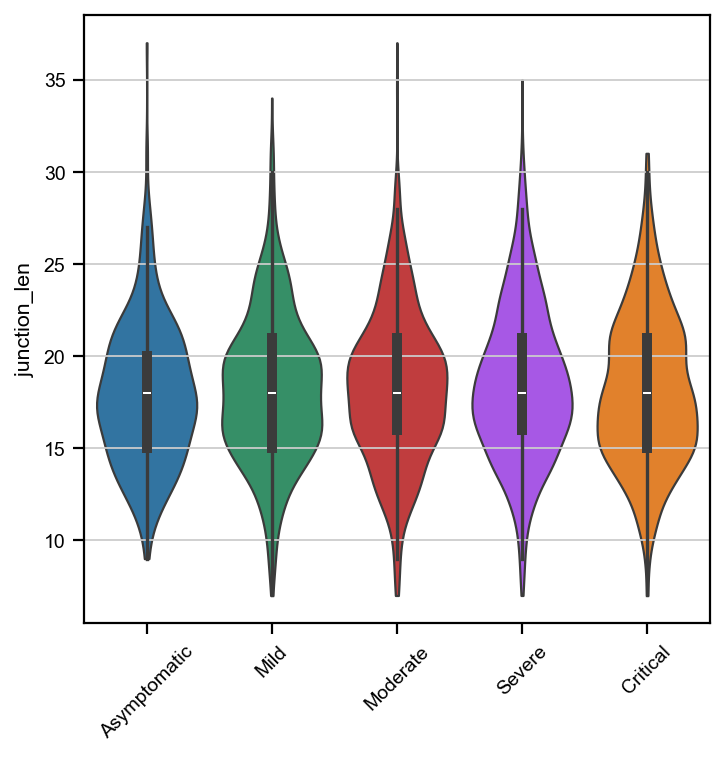

In [59]:
with ir.get.obs_context(
    mdata["gex"], {"junction_len": [len(a) for a in ir.get.airr(mdata, "junction_aa", "VDJ_1")]}
) as m:
    sc.pl.violin(
        m,
        "junction_len",
        groupby="Status_on_day_collection_summary",
        stripplot=False,
        inner="box",
        rotation=45,
        order=["Asymptomatic", "Mild", "Moderate", "Severe", "Critical"],
    )

## Logoplots

TODO

## Analysing somatic hypermutation

TODO